In [1]:
import xarray as xr
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Let's step through the analysis

Temperature patterns at the surface are driven by changes in atmospheric pressure (more specifically - jet level changes). We could spend some time optimizing the atmospheric level pressure pattern predictor, but for the sake of simplicity, here we will just look at 500-hPa geopotential height. This is a good first guess, as vorticity at 500-hPa drives storm systems at lower levels, and is directly influenced by jet-level (200-hPa dynamics). These relationships will be much weaker in the summer, as the atmosphere is much less baroclinic (weaker temperature gradient from equator to pole), resulting in weaker dynamics. 

The ensemble gives us 21 possible trajectories. We are assessing the how *linear* changes in the 1 - 5 day average 500-hPa circulation might lead to changes in the 6 - 10 day US CDD distribution. This isn't a terrible assumption, lag correlations of 500-hPa and US temps will show signal out to 5 days, but the dynamics that drive circulation are non-linear. To make matters worse, errors are already growing exponentially in the model by day 5 (error growth due to physical parameterizations, like clouds, saturate by day 2 and then grow upscale), so we are inherently assuming the errors will grow similarly in the 06z run. Statistically, the 06z skill is no different than the 00z run, especially in the 6 - 10, but the error growth could be substantially different run to run. If we had an ensemble distribution that captured the full range of outcomes, we could worry less about this. To that end, this type of analysis on the ECMWF distribution might prove more fruitful.

So, let's load in the 500-hPa geopotential height for the 00z run, and CDDs. We resample to daily mean geopotential height since we are going to smooth this anyway, and only take gridpoints where latitude is between 0 to 90N.

In [2]:
# this is the 500-hPa forecast from 00z run
fcst1=xr.open_dataset(
    'http://thredds-jetstream.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/GEFS_Global_1p0deg_Ensemble_20200531_0000.grib2',
    chunks={'ens': 21}
)
h500=fcst1.Geopotential_height_isobaric_ens.sel(isobaric3=50000,lat=slice(90,0)).resample(time2='D').mean().compute()

cdds=pd.read_csv('gfs-ens_cdds_20200531.csv')

# take only the 00z panels, since these are not generated from daily max/min temperature
cdds00=cdds[cdds.run=='gfs-ens-00z'].cdds.values.reshape(65,21)[1::4] # shift 6H to align with gfs-ens-06z
cdds06=cdds[cdds.run=='gfs-ens-06z'].cdds.values.reshape(65,21)[::4]

We will apply the coefficients from the 00Z regression to the 1-5 day 06z geopotential height patterns so let's get that loaded in. In real time, we would have to wait for the 1-5 day forecast to become available before we can run this prediction. But, we would have a prediction of the 6-10 accumulated CDDs, before the 06z 6 - 10 day forecast was available, which *could* be used to trade market volatility, if this was skillful and we thought there would be a lot of movement in natural gas. I do not have much confidence that this would skillful with the GEFS without a significant amount of effort.

In [3]:
# This is the 500-hPa forecast from the 06z run
fcst2=xr.open_dataset(
    'http://thredds-jetstream.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/GEFS_Global_1p0deg_Ensemble_20200531_0600.grib2',
    chunks={'ens': 21}
)
h500_2=fcst2.Geopotential_height_isobaric_ens.sel(isobaric3=50000,lat=slice(90,0)).resample(time='D').mean().compute()

Our predictor is the 1 - 5 day mean 500-hPa height pattern in actuality, because day 0 is not complete in the 06z run, but this could be tuned to any window. 5-day means might not provide enough clarity, for example, 3-day means could better capture the atmospheric evolution. With a long enough training dataset, we could try to assess those relationships. We have a predictor matrix of [21obs x (nlat x nlon) features]. For simplicity, this is trained on the northern hemisphere circulation. Generally speaking during this time of year, it is a bad assumption to say pressure over Spain will drive US temperatures 5 days from now, since atmospheric waves move from west to east.

__Note__: In a perfect world, the predicted 500-hPa height pattern would be standardized by the model spread and model climatology (which is different from observed climatology!!!), which can be calculated from the reforecast datasets (e.g. Schiraldi and Roundy, 2017). 

Our predictand is the 6 - 10 day accumulated CDD distribution.
Our predictor set is [21 obs x 91*360 gridpoints]. This is unrealistic, we would project the H500 forecast onto the leading patterns of H500 variability, to get the predictor set to [21 obs x ~15 predictors]

In [4]:
X=sm.add_constant(h500.isel(time2=slice(1,4)).mean('time2').values.reshape((21,91*360)))
Y=cdds00[5:9,:].sum(axis=0)

mdl = sm.OLS(Y,X).fit()
Ypred=mdl.predict(
    sm.add_constant(h500_2.isel(time=slice(1,4)).mean('time').values.reshape((21,91*360)))
)

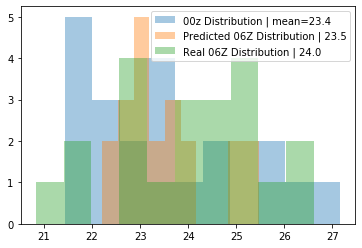

In [5]:
Yreal=cdds06[5:9,:].sum(axis=0)

fig,ax=plt.subplots()
ax.hist(Y,label=f'00z Distribution | mean={Y.mean():0.1f}',alpha=0.4)
ax.hist(Ypred,label=f'Predicted 06Z Distribution | {Ypred.mean():0.1f}',alpha=0.4)
ax.hist(Yreal,label=f'Real 06Z Distribution | {Yreal.mean():0.1f}',alpha=0.4)
ax.legend()

In conclusion, our model predict the 6-10 day accumulated CDDs would be warmer than the 00z run. 